In [11]:
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import pandas as pd
import copy
import pkg_resources
from numpy import ndarray
from numpy.typing import NDArray
from dataclasses import dataclass
from typing import Callable, List, Optional


In [12]:
from trachoma.trachoma_functions import *
import multiprocessing
from joblib import Parallel, delayed
import pkg_resources
num_cores = multiprocessing.cpu_count()

#############################################################################################################################
#############################################################################################################################

# initialize parameters, sim_params, and demography

params = {'N': 4000,
          'av_I_duration' : 2,
          'av_ID_duration':200/7,
          'inf_red':0.45,
          'min_ID':11, #Parameters relating to duration of infection period, including ID period
          'av_D_duration':300/7,
          'min_D':1, #Parameters relating to duration of disease period
          'v_1':1,
          'v_2':2.6,
          'phi':1.4,
          'epsilon':0.5,#Parameters relating to lambda function- calculating force of infection
          #Parameters relating to MDA
          'MDA_Cov':0.8,
          'MDA_Eff': 0.85, # Efficacy of treatment
          'rho':0.3,
          'nweeks_year':52,
          'babiesMaxAge':0.5, #Note this is years, need to check it converts to weeks later
          'youngChildMaxAge':9,#Note this is years, need to check it converts to weeks later
          'olderChildMaxAge':15, #Note this is years, need to check it converts to weeks later
          'b1':1,#this relates to bacterial load function
          'ep2':0.114,
          'n_inf_sev':38,
          'TestSensitivity': 0.96,
          'TestSpecificity': 0.965,
          'SecularTrendIndicator': 0,
          'SecularTrendYearlyBetaDecrease': 0.01,
          'vacc_prob_block_transmission':  0.6, 
          'vacc_reduce_bacterial_load': 1, 
          'vacc_reduce_duration': 1,
          'vacc_coverage': 0,  
          'vacc_waning_length': 52 * 5}


burnin = 100*52
timesim = burnin + 89*52 # burnin is roughly at 2011. 41*52 gets you to 2052

sim_params = {'timesim': timesim, 
              'burnin': burnin,
              'N_MDA':5, # irrelevant due to input method
              'n_sim':100}


demog = {'tau': 0.0004807692, 
         'max_age': 3120,
         'mean_age': 1040}



previous_rounds = 0


Start_date = date(2010,1, 1)
End_date = date(2040,12,31)


## Modifying Matt's updated run folder to include the version of sim_Ind_MDA which includes vaccination. Need to update/match inputs for SimulationFunction.

In [13]:
def seed_to_state(seed):
    np.random.seed(seed)
    return np.random.get_state()

outputYear = range(2019, 2041) # CHECK this, was 2019 to 2041
outputTimes = getOutputTimes(outputYear)
outputTimes = get_Intervention_times(outputTimes, Start_date, sim_params['burnin'])

# this is essentially the same as the original version of the Trachoma_Simulation function

def SimulationFunction(params, sim_params, demog, MDA_times, MDAData, vacc_times, VaccData, seed_bump, beta):

    # Longitudinal simulations:

    # Setting beta; the higher this is the higher the prevalence. 0.12 has prevalence around 20%
    #bet = np.random.uniform(size=sim_params['n_sim'], low=0.1, high=0.12)
    bet = np.ones(sim_params['n_sim']) * beta
    # Run multiple simulations
    def multiple_simulations(i):
        seed = i * seed_bump

        # Generate some random numbers
        np.random.seed(seed)
# we generate a numpy state for each simulation by saving a state. If the seed is set above, this will be consistent from run to run
        numpy_states = list(map(lambda s: seed_to_state(s), np.random.randint(2^32, size=1)))
        vals = Set_inits(params=params, demog=demog, sim_params = sim_params, MDAData=MDAData, numpy_state = numpy_states[0])    # Set initial conditions
        vals = Seed_infection(params=params, vals=vals) # Seed infection
        
        # vals = Check_and_init_MDA_and_survey_counts(vals, numpy_states[0])
        
        vals = Check_and_init_vaccination_state(params,vals)
        
        vals = Check_and_init_MDA_treatment_state(params, vals, MDAData, numpy_state=numpy_states[0])
        
        out, results = sim_Ind_MDA_Include_Survey(params, vals, timesim, burnin, demog, bet[i], MDA_times, MDAData, vacc_times, VaccData, outputTimes, doSurvey = False, doIHMEOutput = False, numpy_state = numpy_states[0])
        return out

    data_store_all_sim = Parallel(n_jobs=num_cores)(delayed(multiple_simulations)(i) for i in range(sim_params['n_sim']))

    return data_store_all_sim




# analyse the runs of the simulations
# we return some aggregated results along with the raw data
def analyseResults(data, sim_params):

    True_Prev_Infection_children_1_9 = np.zeros(shape=(sim_params['timesim'] , sim_params['n_sim']))
    True_Prev_Disease_children_1_9 = np.zeros(shape=(sim_params['timesim'] , sim_params['n_sim']))
    True_Prev_Disease = np.zeros(shape=(sim_params['timesim'] , sim_params['n_sim']))
    True_Prev_Infection = np.zeros(shape=(sim_params['timesim'] , sim_params['n_sim']))
    Time = np.arange(sim_params['timesim'] )
    
    resurges = 0
    
    for i in range(sim_params['n_sim']):

        True_Prev_Disease[:, i] = data[i]['True_Prev_Disease'][0: sim_params['timesim']]
        True_Prev_Infection[:, i] = data[i]['True_Prev_Infection'][0: sim_params['timesim']]
        True_Prev_Infection_children_1_9[:, i] = data[i]['True_Prev_Infection_children_1_9'][0: sim_params['timesim']]
        True_Prev_Disease_children_1_9[:, i] = data[i]['True_Prev_Disease_children_1_9'][0: sim_params['timesim']]
        
        if data[i]['True_Prev_Disease'][-1] > 0:
            resurges += 1

    
    results = pd.DataFrame({'Time': Time / 52,
                            'Mean_Disease_Children': np.mean(True_Prev_Disease_children_1_9, axis=1),
                            'Mean_Infection_Children': np.mean(True_Prev_Infection_children_1_9, axis=1),
                            'Mean_Disease_All': np.mean(True_Prev_Disease, axis=1),
                            'Mean_Infection_All': np.mean(True_Prev_Infection, axis=1),
                            'Median_Disease_Children': np.median(True_Prev_Disease_children_1_9, axis=1),
                            'Median_Infection_Children': np.median(True_Prev_Infection_children_1_9, axis=1),
                            'Median_Disease_All': np.median(True_Prev_Disease, axis=1),
                            'Median_Infection_All': np.median(True_Prev_Infection, axis=1),
                            })

    POR = resurges/sim_params['n_sim']
    
    return results, POR # removed output of entire prevalences from each run. put [0] after output if this changes


# Add in PROBABILITY OF OUTBREAK indicator, returning a percentage for prob of elimination to tag onto each line


# function to get the MDA data for the specified coverage file
def get_MDA_data(coverageFileName):
    MDAData = readPlatformData(coverageFileName, "MDA")
    MDA_dates = getInterventionDates(MDAData)
    MDA_times = get_Intervention_times(MDA_dates, Start_date, sim_params['burnin'])
    return MDAData, MDA_times

# function to get the vaccination data for the specified coverage file
def get_vacc_data(coverageFileName):
    VaccData = readPlatformData(coverageFileName, "Vaccine")
    vacc_dates = getInterventionDates(VaccData)
    vacc_times = get_Intervention_times(vacc_dates, Start_date, sim_params['burnin'])
    return VaccData, vacc_times

In [14]:

seed = 100
beta = 0.17


## Scenarios chosen by Ellie and Claudio

In [15]:
# loading in each scenario - currently just two and a baseline
MDADataM1, MDA_timesM1 = get_MDA_data("scen_ellie_m1.csv")
VaccDataM1, vacc_timesM1 = get_vacc_data("scen_ellie_m1.csv")

MDADataBL, MDA_timesBL = get_MDA_data("scen_ellie_bl.csv")
VaccDataBL, vacc_timesBL = get_vacc_data("scen_ellie_bl.csv")

MDADataCW, MDA_timesCW = get_MDA_data("scen_ellie_cw.csv")
VaccDataCW, vacc_timesCW = get_vacc_data("scen_ellie_cw.csv")

MDADataCO, MDA_timesCO = get_MDA_data("scen_ellie_co.csv")
VaccDataCO, vacc_timesCO = get_vacc_data("scen_ellie_co.csv")

In [16]:
res_el = {} # store results for ellie scenarios

In [17]:
# runs -1 to 4

# -1 involves MDA instead of vaccination in 2028

data_el_m1 = SimulationFunction(params, sim_params, demog, MDA_timesM1, MDADataM1, vacc_timesM1, VaccDataM1, seed_bump = seed, beta = beta)
res_el['-1'] = analyseResults(data_el_m1, sim_params)

# 0 involves no vaccination or MDA in 2028

data_el_0 = SimulationFunction(params, sim_params, demog, MDA_timesBL, MDADataBL, vacc_timesBL, VaccDataBL, seed_bump = seed, beta = beta)
res_el['0'] = analyseResults(data_el_0, sim_params)

params['vacc_prob_block_transmission'] = 0.5
params['vacc_waning_length'] = 1 * 52

data_el_1 = SimulationFunction(params, sim_params, demog, MDA_timesCO, MDADataCO, vacc_timesCO, VaccDataCO, seed_bump = seed, beta = beta)
res_el['1'] = analyseResults(data_el_1, sim_params)

data_el_2 = SimulationFunction(params, sim_params, demog, MDA_timesCW, MDADataCW, vacc_timesCW, VaccDataCW, seed_bump = seed, beta = beta)
res_el['2'] = analyseResults(data_el_2, sim_params)

params['vacc_waning_length'] = 15 * 52

data_el_3 = SimulationFunction(params, sim_params, demog, MDA_timesCO, MDADataCO, vacc_timesCO, VaccDataCO, seed_bump = seed, beta = beta)
res_el['3'] = analyseResults(data_el_3, sim_params)

data_el_4 = SimulationFunction(params, sim_params, demog, MDA_timesCW, MDADataCW, vacc_timesCW, VaccDataCW, seed_bump = seed, beta = beta)
res_el['4'] = analyseResults(data_el_4, sim_params)

In [18]:
# runs 5 to 8

params['vacc_prob_block_transmission'] = 0.9
params['vacc_waning_length'] = 1 * 52

data_el_5 = SimulationFunction(params, sim_params, demog, MDA_timesCO, MDADataCO, vacc_timesCO, VaccDataCO, seed_bump = seed, beta = beta)
res_el['5'] = analyseResults(data_el_5, sim_params)

data_el_6 = SimulationFunction(params, sim_params, demog, MDA_timesCW, MDADataCW, vacc_timesCW, VaccDataCW, seed_bump = seed, beta = beta)
res_el['6'] = analyseResults(data_el_6, sim_params)

params['vacc_waning_length'] = 15 * 52

data_el_7 = SimulationFunction(params, sim_params, demog, MDA_timesCO, MDADataCO, vacc_timesCO, VaccDataCO, seed_bump = seed, beta = beta)
res_el['7'] = analyseResults(data_el_7, sim_params)

data_el_8 = SimulationFunction(params, sim_params, demog, MDA_timesCW, MDADataCW, vacc_timesCW, VaccDataCW, seed_bump = seed, beta = beta)
res_el['8'] = analyseResults(data_el_8, sim_params)

In [19]:
pors_el = {}
for i in range(-1,9):
    pors_el[i] = [res_el[str(i)][1]]

pors_el = pd.DataFrame(pors_el)
pors_el.index = ['POR']
pors_el

,-1,0,1,2,3,4,5,6,7,8
POR,0.66,0.75,0.31,0.02,0.28,0.0,0.13,0.0,0.29,0.0


(2018.0, 2042.0)

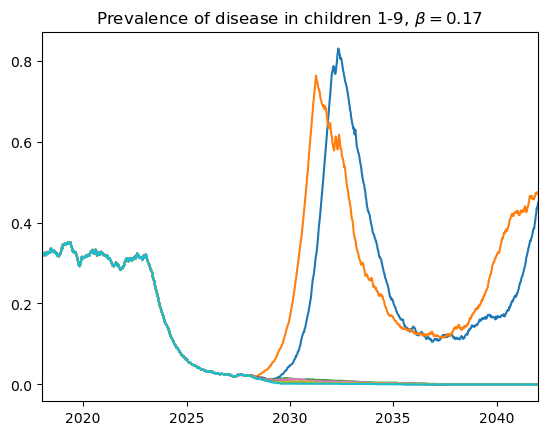

In [25]:
import matplotlib.pyplot as plt
start_year = 2010-burnin/52 # was 2018 - check to match csv dates

scenarios = [-1,0,1,2,3,4,5,6,7,8]

for i in scenarios:
    plt.plot(start_year + np.array(res_el[str(0)][0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_el[str(i)][0]['Median_Disease_Children'][(sim_params['burnin']-100): sim_params['timesim']]))

#plt.legend(['Scen' + str(i) for i in scenarios]) 
plt.title(r"Prevalence of disease in children 1-9, $\beta=0.17$")
plt.xlim([2018,2042])

(2018.0, 2042.0)

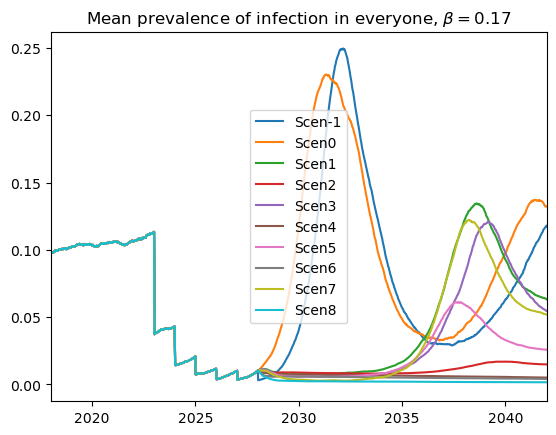

In [35]:
scenarios = [-1,0,1,2,3,4,5,6,7,8]

for i in scenarios:
    plt.plot(start_year + np.array(res_el[str(0)][0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_el[str(i)][0]['Mean_Infection_All'][(sim_params['burnin']-100): sim_params['timesim']]))
    
plt.legend(['Scen' + str(i) for i in scenarios]) 
plt.title(r"Mean prevalence of infection in everyone, $\beta=0.17$")
plt.xlim([2018,2042])
#plt.xlim([2027, 2041])
#plt.ylim([0,0.05])

## Export

In [28]:
# create data frame storing the median infection in children (could do all instead) for each scenario
export_el_inf_init = {}
for i in range(-1,9):
    export_el_inf_init['scen'+str(i)+'_inf'] = res_el[str(i)][0]['Median_Infection_Children']
export_el_inf = pd.DataFrame(export_el_inf_init)


# same but for disease
export_el_dis_init = {}
for i in range(-1,9):
    export_el_dis_init['scen'+str(i)+'_dis'] = res_el[str(i)][0]['Median_Disease_Children']
export_el_dis = pd.DataFrame(export_el_dis_init)

In [ ]:
#export_el_inf.to_csv('scenario_el_inf17.csv', index=True)
#export_el_dis.to_csv('scenario_el_dis17.csv', index=True)

In [29]:
print(MDA_timesCO)

[5878 5930 5982 6034 6087]


## Delay scenarios D0-4

In [31]:
# all community wide
MDADataD0, MDA_timesD0 = get_MDA_data("scen_lp_d0.csv")
VaccDataD0, vacc_timesD0 = get_vacc_data("scen_lp_d0.csv")
MDADataD1, MDA_timesD1 = get_MDA_data("scen_lp_d1.csv")
VaccDataD1, vacc_timesD1 = get_vacc_data("scen_lp_d1.csv")
MDADataD2, MDA_timesD2 = get_MDA_data("scen_lp_d2.csv")
VaccDataD2, vacc_timesD2 = get_vacc_data("scen_lp_d2.csv")
MDADataD3, MDA_timesD3 = get_MDA_data("scen_lp_d3.csv")
VaccDataD3, vacc_timesD3 = get_vacc_data("scen_lp_d3.csv")
MDADataD4, MDA_timesD4 = get_MDA_data("scen_lp_d4.csv")
VaccDataD4, vacc_timesD4 = get_vacc_data("scen_lp_d4.csv")

In [32]:
params['vacc_prob_block_transmission'] = 0.9
params['vacc_waning_length'] = 5 * 52 # chosen FIVE as middle of the road vaccine

In [33]:
res_lp_d = [[] for _ in range(5)]

#data_lo_dm1

beta = 0.17 # lower prevalence for delay runs

data_lp_d0 = SimulationFunction(params, sim_params, demog, MDA_timesD0, MDADataD0, vacc_timesD0, VaccDataD0, seed_bump = seed, beta = beta)
res_lp_d[0] = analyseResults(data_lp_d0, sim_params)

data_lp_d1 = SimulationFunction(params, sim_params, demog, MDA_timesD1, MDADataD1, vacc_timesD1, VaccDataD1, seed_bump = seed, beta = beta)
res_lp_d[1] = analyseResults(data_lp_d1, sim_params)

data_lp_d2 = SimulationFunction(params, sim_params, demog, MDA_timesD2, MDADataD2, vacc_timesD2, VaccDataD2, seed_bump = seed, beta = beta)
res_lp_d[2] = analyseResults(data_lp_d2, sim_params)

data_lp_d3 = SimulationFunction(params, sim_params, demog, MDA_timesD3, MDADataD3, vacc_timesD3, VaccDataD3, seed_bump = seed, beta = beta)
res_lp_d[3] = analyseResults(data_lp_d3, sim_params)

data_lp_d4 = SimulationFunction(params, sim_params, demog, MDA_timesD4, MDADataD4, vacc_timesD4, VaccDataD4, seed_bump = seed, beta = beta)
res_lp_d[4] = analyseResults(data_lp_d4, sim_params)

MemoryError: 

In [353]:
pors_delay = {}
for i in range(5):
    pors_delay[i] = [res_lp_d[i][1]]
    
pors_delay = pd.DataFrame(pors_delay)
pors_delay.index = ['POR']
pors_delay

,0,1,2,3,4
POR,0.0,0.0,0.0,0.0,0.0


In [30]:
start_year = 2010-burnin/52 # was 2018 - check to match csv dates

scenarios = [0,1,2,3,4]

for i in scenarios:
    plt.plot(start_year + np.array(res_lp_d[0][0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_lp_d[i][0]['Median_Disease_Children'][(sim_params['burnin']-100): sim_params['timesim']]))
    
plt.plot(start_year + np.array(res_el[0][0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_el[0][0]['Median_Disease_Children'][(sim_params['burnin']-100): sim_params['timesim']]), color = 'grey')

#plt.legend(['Scen' + str(i) for i in scenarios]) 
plt.title(r"Prevalence of disease in children 1-9, $\beta=0.17$")
plt.xlim([2018,2047])
#plt.xlim([2026, 2031])
#plt.ylim([-0.001, 0.08])

NameError: name 'res_lp_d' is not defined

(2018.0, 2047.0)

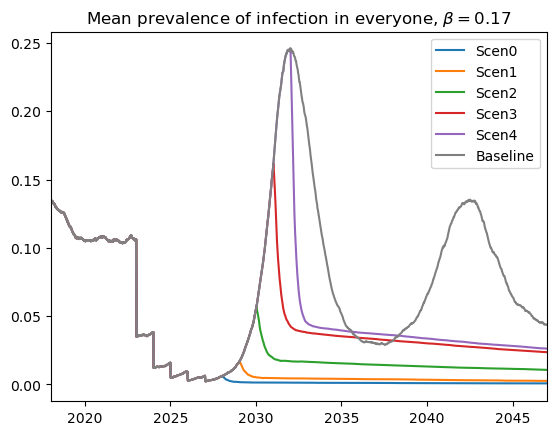

In [328]:
scenarios = [0,1,2,3,4]

for i in scenarios:
    plt.plot(start_year + np.array(res_lp_d[0][0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_lp_d[i][0]['Mean_Infection_All'][(sim_params['burnin']-100): sim_params['timesim']]))

plt.plot(start_year + np.array(res_el[0][0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_el[0][0]['Mean_Infection_All'][(sim_params['burnin']-100): sim_params['timesim']]), label = 'Baseline', color = 'grey')

plt.legend(['Scen' + str(i) for i in scenarios] + ['Baseline']) 
plt.title(r"Mean prevalence of infection in everyone, $\beta=0.17$")
plt.xlim([2018,2047])
#plt.xlim([2027, 2041])
#plt.ylim([0,0.05])

## Bonus rounds B1a-B4b after regular 2028 C.O. vaccination w/ beta = 0.22

In [305]:
MDADataB1a, MDA_timesB1a = get_MDA_data("scen_b1a.csv")
VaccDataB1a, vacc_timesB1a = get_vacc_data("scen_b1a.csv")
MDADataB1b, MDA_timesB1b = get_MDA_data("scen_b1b.csv")
VaccDataB1b, vacc_timesB1b = get_vacc_data("scen_b1b.csv")

MDADataB2a, MDA_timesB2a = get_MDA_data("scen_b2a.csv")
VaccDataB2a, vacc_timesB2a = get_vacc_data("scen_b2a.csv")
MDADataB2b, MDA_timesB2b = get_MDA_data("scen_b2b.csv")
VaccDataB2b, vacc_timesB2b = get_vacc_data("scen_b2b.csv")

MDADataB3a, MDA_timesB3a = get_MDA_data("scen_b3a.csv")
VaccDataB3a, vacc_timesB3a = get_vacc_data("scen_b3a.csv")
MDADataB3b, MDA_timesB3b = get_MDA_data("scen_b3b.csv")
VaccDataB3b, vacc_timesB3b = get_vacc_data("scen_b3b.csv")

MDADataB4a, MDA_timesB4a = get_MDA_data("scen_b4a.csv")
VaccDataB4a, vacc_timesB4a = get_vacc_data("scen_b4a.csv")
MDADataB4b, MDA_timesB4b = get_MDA_data("scen_b4b.csv")
VaccDataB4b, vacc_timesB4b = get_vacc_data("scen_b4b.csv")

In [306]:
beta = 0.22
params['vacc_prob_block_transmission'] = 0.9
params['vacc_waning_length'] = 5 * 52

In [307]:
res_bonus = {}

data_b0 = SimulationFunction(params, sim_params, demog, MDA_timesCO, MDADataCO, vacc_timesCO, VaccDataCO, seed_bump = seed, beta = beta)
res_bonus['b0'] = analyseResults(data_b0, sim_params)

data_b1a = SimulationFunction(params, sim_params, demog, MDA_timesB1a, MDADataB1a, vacc_timesB1a, VaccDataB1a, seed_bump = seed, beta = beta)
res_bonus['b1a'] = analyseResults(data_b1a, sim_params)
data_b1b = SimulationFunction(params, sim_params, demog, MDA_timesB1b, MDADataB1b, vacc_timesB1b, VaccDataB1b, seed_bump = seed, beta = beta)
res_bonus['b1b'] = analyseResults(data_b1b, sim_params)

data_b2a = SimulationFunction(params, sim_params, demog, MDA_timesB2a, MDADataB2a, vacc_timesB2a, VaccDataB2a, seed_bump = seed, beta = beta)
res_bonus['b2a'] = analyseResults(data_b2a, sim_params)
data_b2b = SimulationFunction(params, sim_params, demog, MDA_timesB2b, MDADataB2b, vacc_timesB2b, VaccDataB2b, seed_bump = seed, beta = beta)
res_bonus['b2b'] = analyseResults(data_b2b, sim_params)

data_b3a = SimulationFunction(params, sim_params, demog, MDA_timesB3a, MDADataB3a, vacc_timesB3a, VaccDataB3a, seed_bump = seed, beta = beta)
res_bonus['b3a'] = analyseResults(data_b3a, sim_params)
data_b3b = SimulationFunction(params, sim_params, demog, MDA_timesB3b, MDADataB3b, vacc_timesB3b, VaccDataB3b, seed_bump = seed, beta = beta)
res_bonus['b3b'] = analyseResults(data_b3b, sim_params)

data_b4a = SimulationFunction(params, sim_params, demog, MDA_timesB4a, MDADataB4a, vacc_timesB4a, VaccDataB4a, seed_bump = seed, beta = beta)
res_bonus['b4a'] = analyseResults(data_b4a, sim_params)
data_b4b = SimulationFunction(params, sim_params, demog, MDA_timesB4b, MDADataB4b, vacc_timesB4b, VaccDataB4b, seed_bump = seed, beta = beta)
res_bonus['b4b'] = analyseResults(data_b4b, sim_params)

In [352]:
pors_bonus = {}
scenarios = ['b0', 'b1a', 'b1b', 'b2a', 'b2b', 'b3a', 'b3b', 'b4a', 'b4b']
for i in scenarios:
    pors_bonus[i] = [res_bonus[i][1]]

pors_bonus = pd.DataFrame(pors_bonus)
pors_bonus.index = ['POR']
pors_bonus

,b0,b1a,b1b,b2a,b2b,b3a,b3b,b4a,b4b
POR,0.68,0.0,0.08,0.0,0.12,0.0,0.04,0.0,0.16


Text(0.5, 1.0, 'Runs of b2b, with probability of resurgence = 0.12')

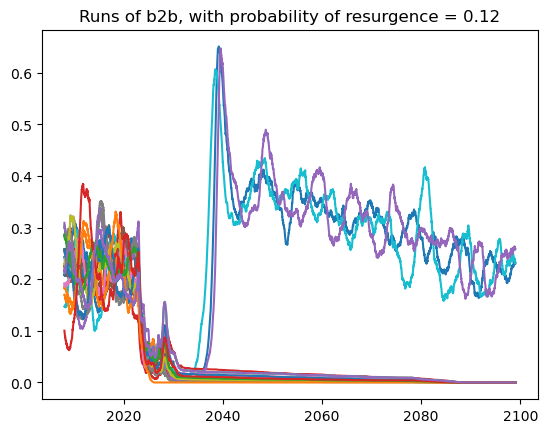

In [317]:
start_year = 2010-burnin/52
for i in range(sim_params['n_sim']):
    plt.plot(start_year + res_bonus['b2b'][0]['Time'][(sim_params['burnin']-100): sim_params['timesim']], data_b2b[i]['True_Prev_Disease'][(sim_params['burnin']-100): sim_params['timesim']])
plt.title('Runs of b2b, with probability of resurgence = '+str(res_bonus['b2b'][1]))

(2018.0, 2042.0)

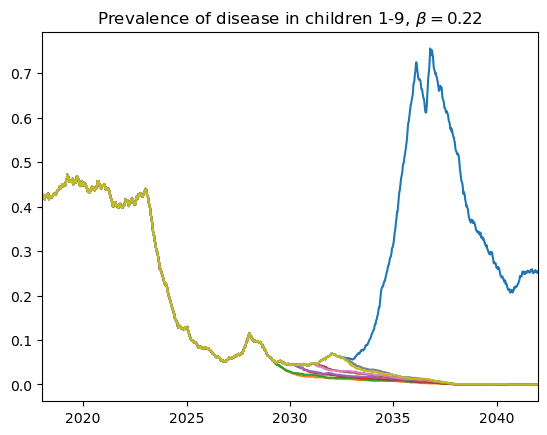

In [310]:
start_year = 2010-burnin/52 # was 2018 - check to match csv dates

scenarios = ['b0', 'b1a', 'b1b', 'b2a', 'b2b', 'b3a', 'b3b', 'b4a', 'b4b']

for i in scenarios:
    plt.plot(start_year + np.array(res_bonus['b0'][0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_bonus[i][0]['Median_Disease_Children'][(sim_params['burnin']-100): sim_params['timesim']]))

#plt.legend(['Scen' + str(i) for i in scenarios]) 
plt.title(r"Prevalence of disease in children 1-9, $\beta=0.22$")
plt.xlim([2018,2042])

(2018.0, 2042.0)

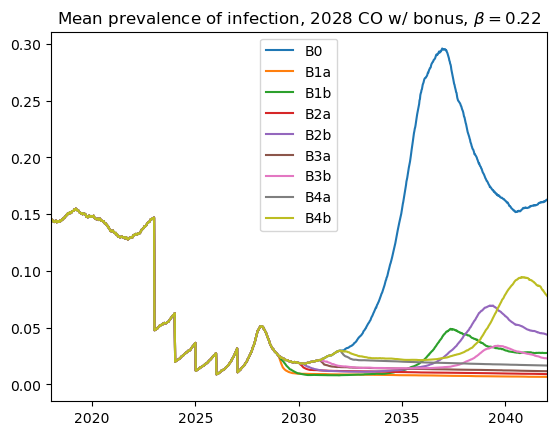

In [333]:
scenarios = ['b0', 'b1a', 'b1b', 'b2a', 'b2b', 'b3a', 'b3b', 'b4a', 'b4b']
#scenarios = ['b1a', 'b2a', 'b3a', 'b4a']
for i in scenarios:
    plt.plot(start_year + np.array(res_bonus['b0'][0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_bonus[i][0]['Mean_Infection_All'][(sim_params['burnin']-100): sim_params['timesim']]))
    
plt.legend([str(i).capitalize() for i in scenarios]) 
plt.title(r"Mean prevalence of infection, 2028 CO w/ bonus, $\beta=0.22$")
plt.xlim([2018,2042])
#plt.ylim([-0.0001, 0.2])
#plt.ylim([0,0.05])

In [312]:
print(VaccDataB1a)
print(VaccDataB2a)
print(VaccDataB3a)
print(VaccDataB4a)

[[2028.0, 0, 10, 0.72, 0, 2], [2029.0, 0, 100, 0.72, 1, 2]]
[[2028.0, 0, 10, 0.72, 0, 2], [2030.0, 0, 100, 0.72, 1, 2]]
[[2028.0, 0, 10, 0.72, 0, 2], [2031.0, 0, 100, 0.72, 1, 2]]
[[2028.0, 0, 10, 0.72, 0, 2], [2032.0, 0, 100, 0.72, 1, 2]]
